<div style="background-color:	#009090; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">DL&CV - Huisprijzen</h1>
<b style="color:white">Tim Oosterling, Declan, Casper De Knecht, Jasper Duncker</b>
    </div>
<a name='start'></a>

## Table of contents

1. [EDA (Exploratory Data Analysis)](#eda)

2. [Data mining](#data)

3. [Fully-connected neuraal netwerk](#dense)
    - [&sect;3.1: Model](#dense)
    - [&sect;3.2: Modelarchitectuur en onderbouwing](#dense-architecture)


4. [Convolutioneel neuraal netwerk (CNN)](#cnn)
    - [&sect;4.1: CNN model](#cnn)
    - [&sect;4.2: Modelarchitectuur en onderbouwing](#cnn-hyperparameters)
    - [&sect;4.3: image-datapipepline](#cnn-datapipepline)
    
    
5. [Transfer learning](#transfer-learning)
    - [&sect;5.1: Transfer-learning model](#transfer-learning)
    - [&sect;5.2: Pretrained model en voordelen](#tl-pretrained)
    - [&sect;5.3: Modelarchitectuur, Keuze en onderbouwing](#tl-hyperparameters)


6. [Multimodaal model](#multimodal)
    - [&sect;6.1: Multimodaal model](#multimodal)
    - [&sect;6.2: Modelarchitectuur, Keuze en onderbouwing hyperparameters en strategie](#mm-hyperparameters)


7. [Bevindingen](#findings)
    - [&sect;7.1: Resultaten](#findings)
    - [&sect;7.2: Best presterende model](#findings-best-model)
    
    
8. [Conclusie en aanbevelingen](#conclusion)
    - [&sect;8.1: Samenvatting van modeleringsproces](#conclusion)
    - [&sect;8.2: Conclusie ](#conclusion-findings)
    - [&sect;8.3: Aanbeveling](#conclusion-recommendations)

<p>Voor het gebruik van de API is de volgende library nodig in Anaconda.</p>


In dit notebook maken wij voorspellingen voor huisprijzen aan de hand van verschillende soorten data: we hebben twee CSV-bestanden en twee mappen met verschillende foto's.

CSV:
We hebben test- en trainings-CSV-bestanden. Hierin kun je 7 kolommen vinden.

HouseID: gewoon de ID van het huis.  
Bedrooms: hier krijgen we te weten hoeveel slaapkamers het huis heeft.  
Bathrooms: het aantal badkamers dat het huis heeft.  
Area: dit is het oppervlakte van het huis in vierkante voet.  
Latitude: de breedtegraad voor de coördinaten van het huis.  
Longitude: de lengtegraad voor de coördinaten.  
Price: de prijs van het huis. Wat we willen gaan voorspellen.

Foto's:  
We hebben ook twee verschillende mappen met foto's. Hier hebben we ook een trainings- en testset. Deze zijn precies hetzelfde, alleen zijn het andere foto's.

Deze foto's bestaan uit 4 verschillende afbeeldingen van het betreffende huis. Zo is er vaak een badkamer, slaapkamer, keuken en een foto van de buitenkant. Deze moeten we gaan gebruiken om ons neurale netwerk te trainen en testen.

[Back to the top](#start)
<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H0: Nuttige def functies </strong></h2>
</div>


In [1]:
#!pip install geopy

In [2]:
# important
import random
import numpy as np
import pandas as pd
#from google.colab.patches import cv2_imshow
#from google.colab import drive
import os
from PIL import Image
from pathlib import Path
#import geopy
#from geopy.geocoders import Nominatim

# Preprocessing
from sklearn.model_selection import train_test_split
import cv2

# Models
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential


#Layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, RandomFlip, RandomRotation, GlobalAveragePooling2D

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Visualisaties
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

In [20]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')
inputPath = "/content/drive/MyDrive/verkoopprijzen-van-huizen-voorspellen/Train"
test_inputPath = "/content/drive/MyDrive/verkoopprijzen-van-huizen-voorspellen/Test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def get_image(row_id):
    """
    Load and return the image corresponding to the given row_id.

    Parameters:
    - row_id (int): The identifier of the image.

    Returns:
    - numpy.ndarray: The loaded image.
    """
    example = cv2.imread(inputPath + f"/{row_id}.jpg")
    return example

def train_test_model(model):
    """
    Traint het opgegeven model met behulp van de meegeleverde trainingsgegevens en evalueert het met de testgegevens.

    Parameters:
    ----------
    model : model vergelijkbaar met sklearn
        Het model dat getraind en geëvalueerd moet worden.

    Returns:
    -------
    RMSE :
        Deze functie drukt de RMSE score van het model op de testgegevens af.


    """

    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = MSE**0.5
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    return print('R2:',R2,
                 '\nMAE:', MAE,
                 '\nMSE:',MSE,
                 '\nRMSE:',RMSE)

def push_dataframe(house_id_values, predictions_values, push=True, csv_file_path=None):
    """
    Creëert een DataFrame met kolommen 'p_id' en 'predictions' en slaat het op naar een CSV-bestand (optioneel).

    Args:
        p_id_values (list): Een lijst met waarden voor de 'p_id'-kolom.
        predictions_values (list): Een lijst met waarden voor de 'predictions'-kolom.
        push (bool): Een boolean die aangeeft of het DataFrame moet worden opgeslagen naar een CSV-bestand.
        csv_file_path (str): Het pad naar het CSV-bestand waarin het DataFrame moet worden opgeslagen (alleen nodig als push=True).

    Returns:
        pd.DataFrame: Een DataFrame met de opgegeven kolommen.
    """

    # Flatten the predictions_values array if it's 2D
    if len(predictions_values.shape) > 1:
        predictions_values = predictions_values.flatten()

    data = {'House ID': house_id_values, 'Price': predictions_values}
    df = pd.DataFrame(data)

    if push and csv_file_path:
        df.to_csv(csv_file_path, index=False)
        print(f"CSV file '{csv_file_path}' has been created.")

    return df

def colab(colab=True):
  """
  Leest train- en testgegevens in vanuit CSV-bestanden, afhankelijk van de omgeving.

  Parameters:
  - colab: Boolean, standaardwaarde is True. Geeft aan of de code in Google Colab wordt uitgevoerd.

  Returns:
  - train: DataFrame, trainingsgegevens
  - test: DataFrame, testgegevens
  """
  if colab:
    inputPath = "/content/drive/MyDrive/verkoopprijzen-van-huizen-voorspellen/"
    train = pd.read_csv(inputPath+'train.csv')
    test = pd.read_csv(inputPath+'test.csv')
  else:
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

  return train, test


def plot(x, hist=True, vline=False, percent=None):
    """
    Plots a histogram and optionally adds a vertical line at a specified percentile.

    Parameters:
    - x (str): The column name for which the histogram should be plotted.
    - hist (bool): If True, plot the histogram. Default is True.
    - vline (bool): If True, add a vertical line at the specified percentile. Default is False.
    - percent (float): The percentile value for the vertical line. Required if vline is True.

    Returns:
    None
    """
    if vline:
        if percent is None:
            raise ValueError("Percent must be specified when vline is True.")

        upper_bound = np.percentile(train[x], percent)
        plt.figure(figsize=(10, 6))
        sns.histplot(train[x], kde=True, color='green')
        plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2, label=f'{percent:.2f}%')
        plt.title(f'{x} met {percent:.2f}% interval')
        plt.legend()
        plt.show()
    elif hist:
        plt.figure(figsize=(10, 6))
        sns.histplot(train[x], kde=True, color='green')
        plt.title(f'Histogram van de {x}')
        plt.show()
    else:
        raise ValueError("At least one of hist or vline must be True.")



[Back to the top](#start)
<a name='eda'></a>

<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: EDA (Exploratory Data Analysis)</strong></h2>
</div>

- [x] Keuze voor visualisaties en interpretatie (5 punten)


Hier in de EDA gaan we kijken naar hoe de data eruit ziet. Doormiddel van tabellen en visualisaties.

In [5]:
train, test = colab(colab=True)
train

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226
...,...,...,...,...,...,...,...
495,496,2,2.0,1257,35.6406,-120.7003,380000
496,497,4,2.0,2072,35.6406,-120.7003,429900
497,498,2,2.0,2213,35.6406,-120.7003,585000
498,499,3,2.5,1500,35.6406,-120.7003,319000


In [6]:
print('shape:',train.shape)
print('collomnamen:',train.columns)

shape: (500, 7)
collomnamen: Index(['House ID', 'Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude',
       'Price'],
      dtype='object')


In [7]:
print("Train dataset:")
print(train.describe())
print("\nTest dataset:")
print(test.describe())

print("Train dataset info:")
print(train.info())

print("\nTest dataset info:")
print(test.info())
print("Train dataset:")
print(train.describe())
print("\nTest dataset:")
print(test.describe())

print("Train dataset info:")
print(train.info())

print("\nTest dataset info:")
print(test.info())


Train dataset:
         House ID    Bedrooms   Bathrooms        Area    Latitude   Longitude  \
count  500.000000  500.000000  500.000000   500.00000  500.000000  500.000000   
mean   250.500000    3.350000    2.669500  2369.64600   35.128844 -116.469049   
std    144.481833    1.172283    1.017578  1208.18261    2.386173    6.554434   
min      1.000000    1.000000    1.000000   701.00000   32.631500 -122.368300   
25%    125.750000    2.000000    2.000000  1440.00000   33.808200 -119.802500   
50%    250.500000    3.000000    2.500000  2097.50000   33.920800 -117.609600   
75%    375.250000    4.000000    3.000000  3104.50000   35.640600 -116.371300   
max    500.000000   10.000000    7.000000  9583.00000   47.791800  -87.885900   

              Price  
count  5.000000e+02  
mean   5.980218e+05  
std    5.240649e+05  
min    2.200000e+04  
25%    2.350000e+05  
50%    5.300000e+05  
75%    7.490000e+05  
max    5.858000e+06  

Test dataset:
         House ID   Bedrooms  Bathrooms   

In [8]:
print("Ontbrekende waarden in train dataset:")
print(train.isnull().sum())

print("\nOntbrekende waarden in test dataset:")
print(test.isnull().sum())


Ontbrekende waarden in train dataset:
House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
Price        0
dtype: int64

Ontbrekende waarden in test dataset:
House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
dtype: int64


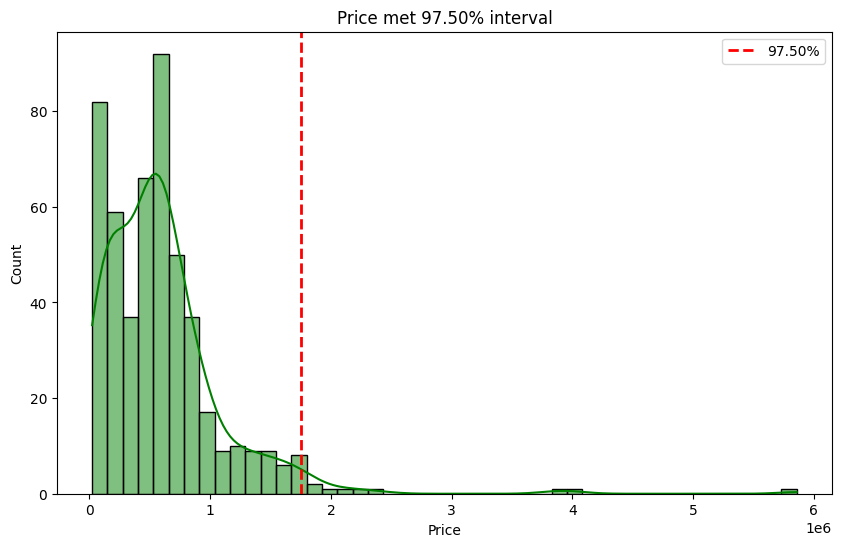

In [9]:
plot('Price', hist=False, vline=True, percent=97.5)


In dit grafiek kunnen we zien hoe de price van de huizen is verdeeld. Zo zien we dat we een paar uitschiters hebben in de dataset. Dit hoeft niet te betekenen dat deze niet thuis horen in de dataset. Want somige huizen worden namelijk soms door veel meer gekocht dan de ander.

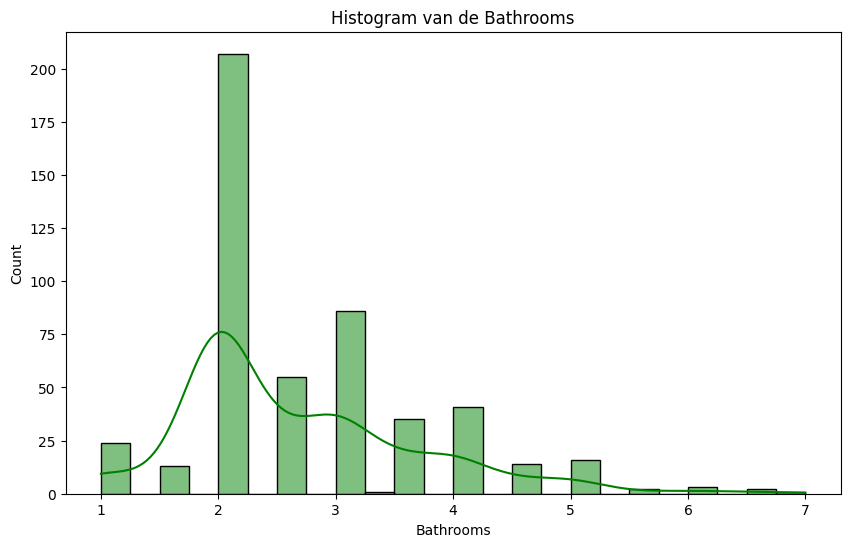

In [10]:
plot('Bathrooms')

Hier hebben we een histogram van de badkamers. We kunnen zien dat de meeste huizen 2 badkamers hebben. Wat wel vreemd is dat somigge huizen blijkbaar .5 of zelfs .25 badkamers hebben. Ik zou geen idee hebben hoe een huis een kwart van een badkamer kan hebben.

In [11]:
print(train['Bathrooms'].unique())
train[train['Bathrooms'] == 3.25]

[4.   3.   5.   3.5  6.5  4.5  2.   5.5  1.   2.5  1.5  7.   6.   3.25]


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
295,296,5,3.25,3149,33.9208,-117.6096,515000


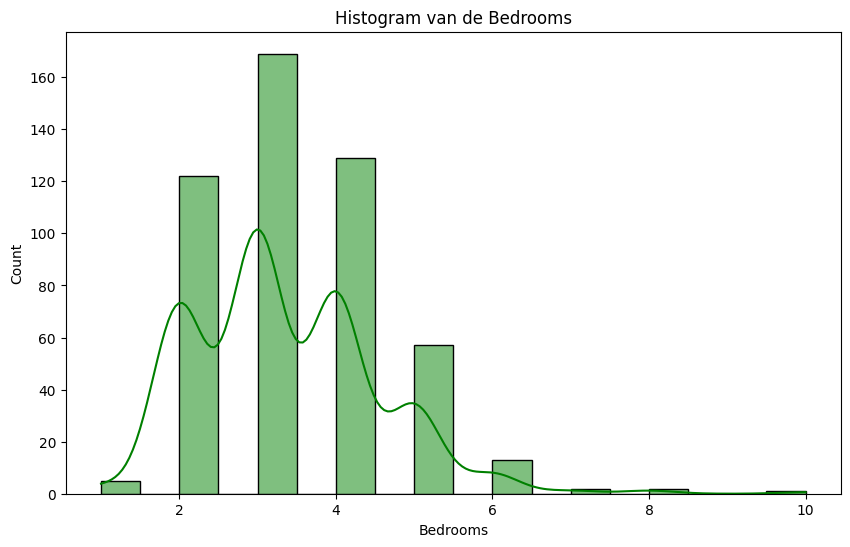

In [12]:
plot('Bedrooms')

Hier staat een histogram van de slaapkamers. De meeste huizen hebben 3 slaapkamers. Hier zien we geen .5 of .25 Het is dus alleen de badkamers die dat heben.

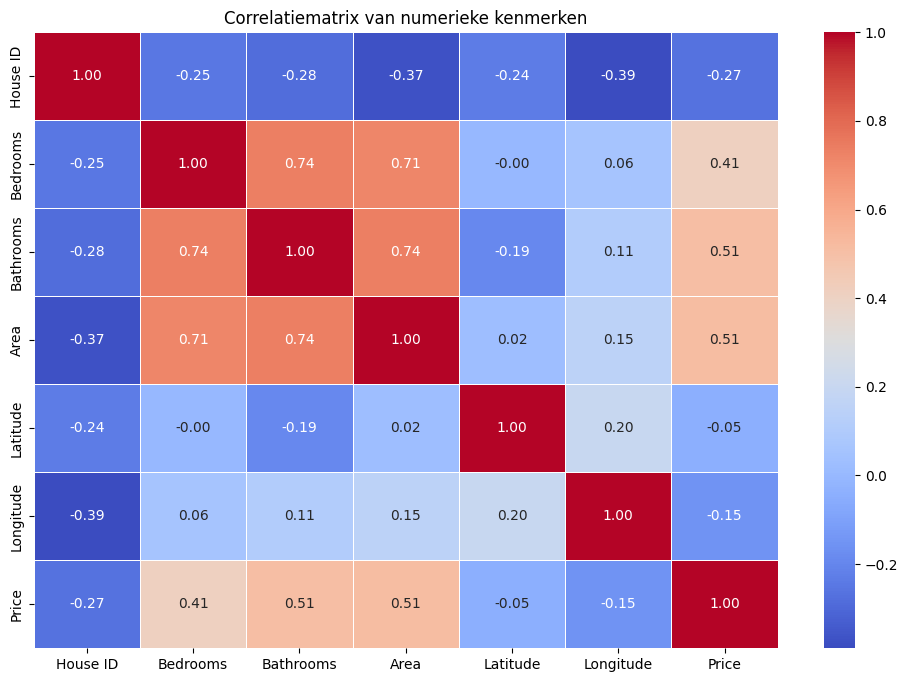

In [13]:
correlation_matrix = train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlatiematrix van numerieke kenmerken')
plt.show()

Dit is een correlatie matrix. Hier zien we dat de area en badkamers het meest invloed geven op de prijs. We zien ook dat de Latitude het mist invloed geeft. Bijna helemaal niks namelijk.

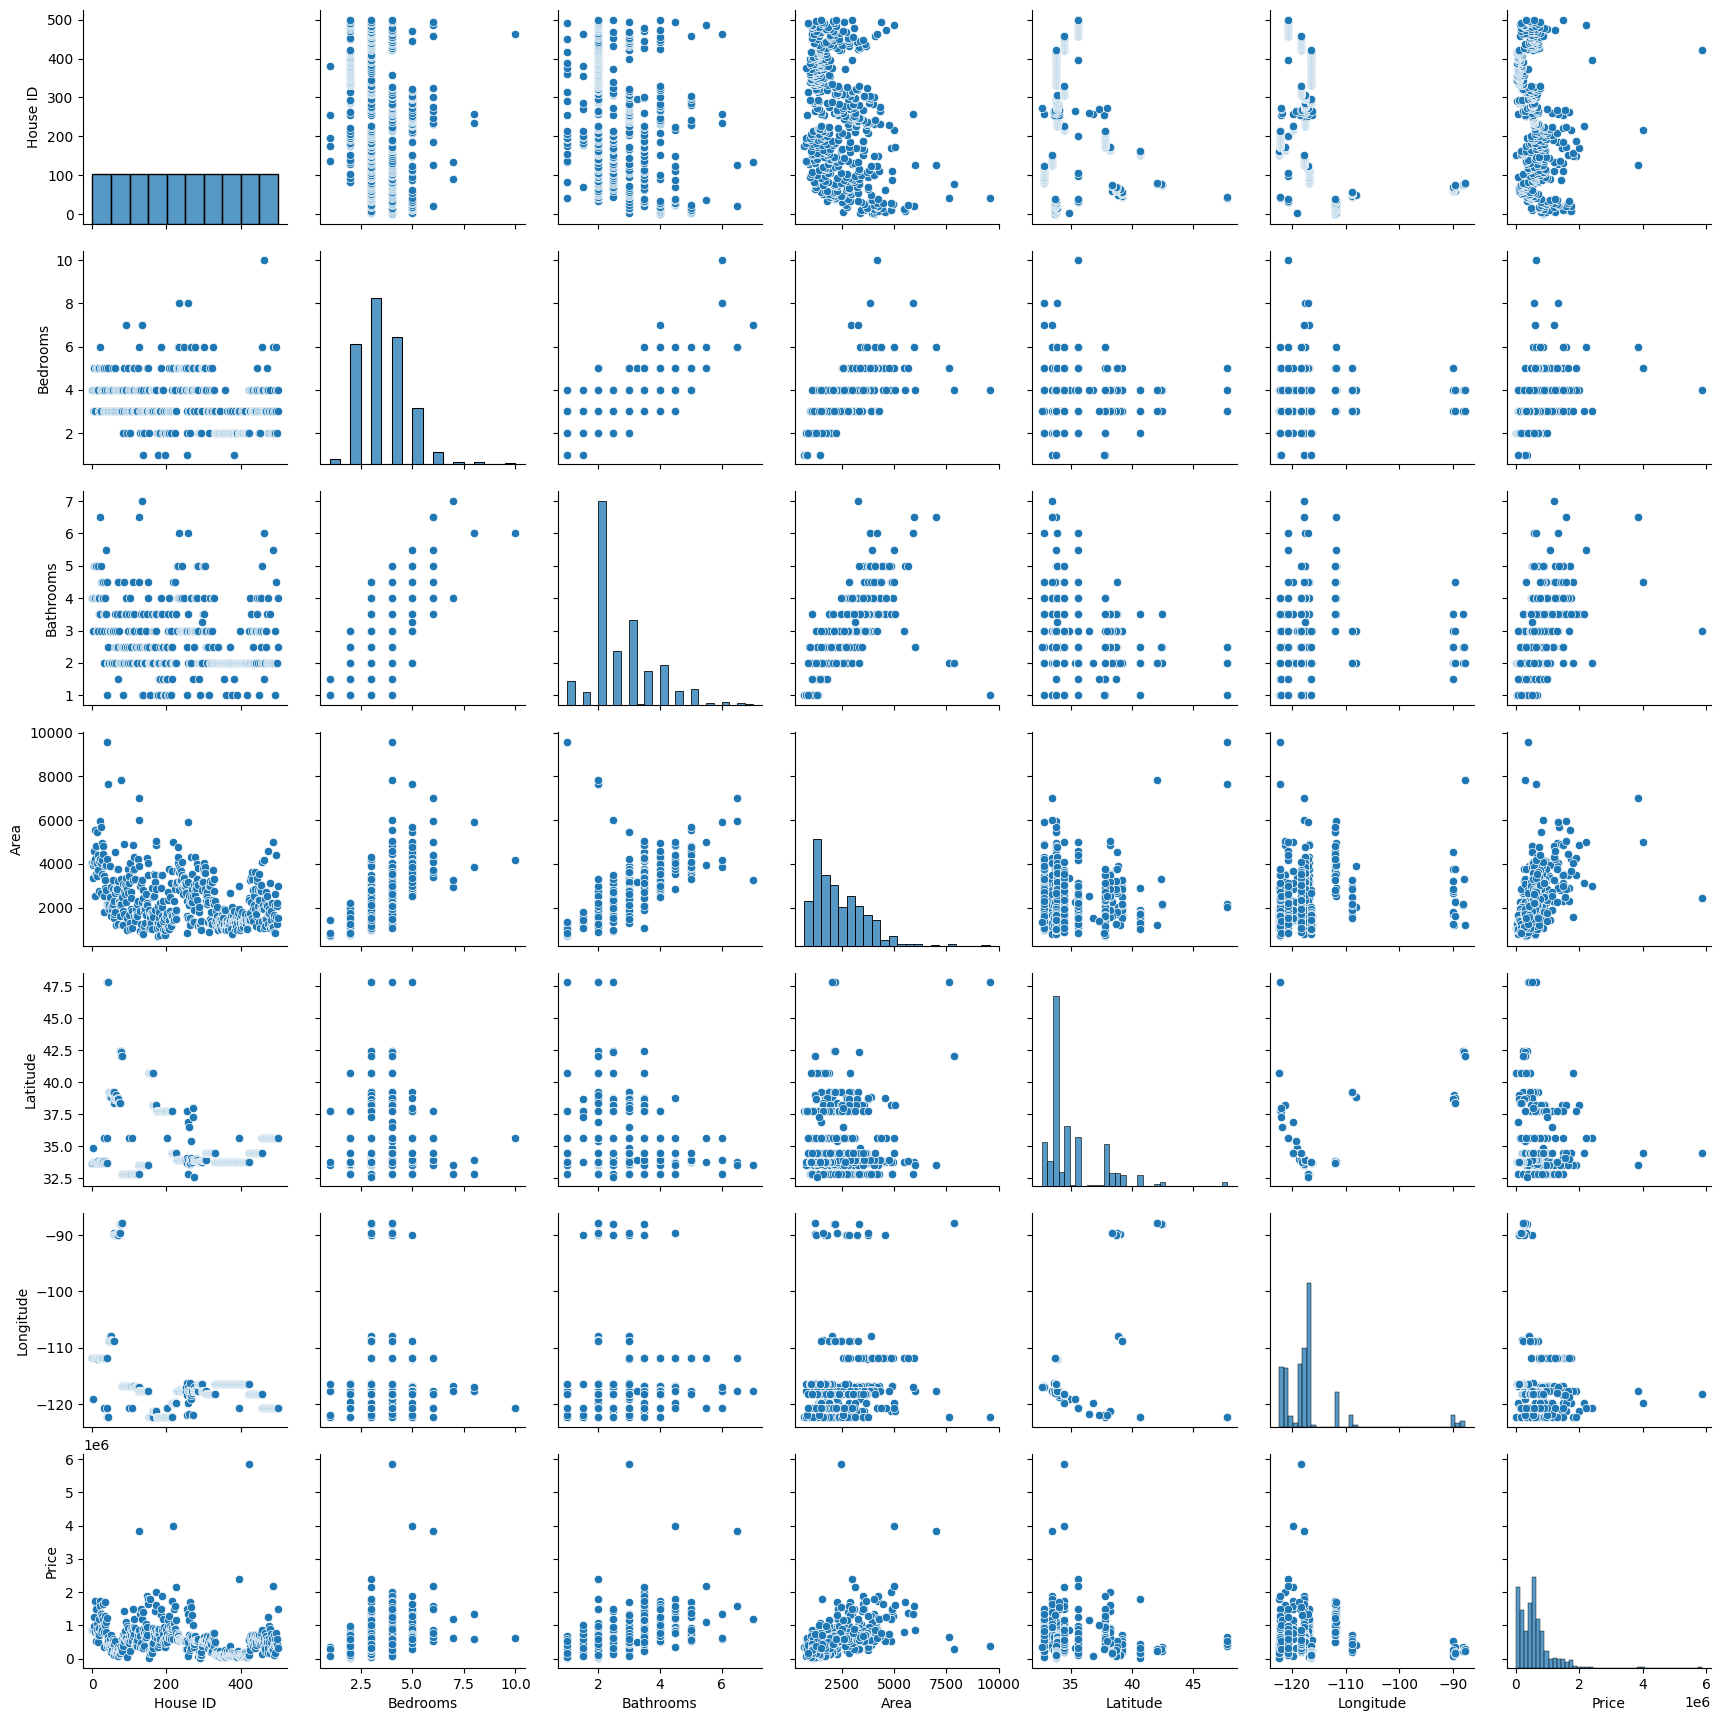

In [14]:
sns.pairplot(train)

Hier kunnen we terug zien van wat we hadden gevonden in de correlatie matrix. Je kan namelijk zien dat bij badkamers, area en slaapkamers een stijgende trend kunt zien. Bij de andere kolommen is het veel moeilijker om een soort trend er uit te kunnen halen.

## Image Dataset
De image dataset bestaat uit 500 images van 4 afbeeldingen, linksboven de badkamer, rechtsboven de slaapkamer, llinksonder de keuken, rechtsonder het huis van buiten.

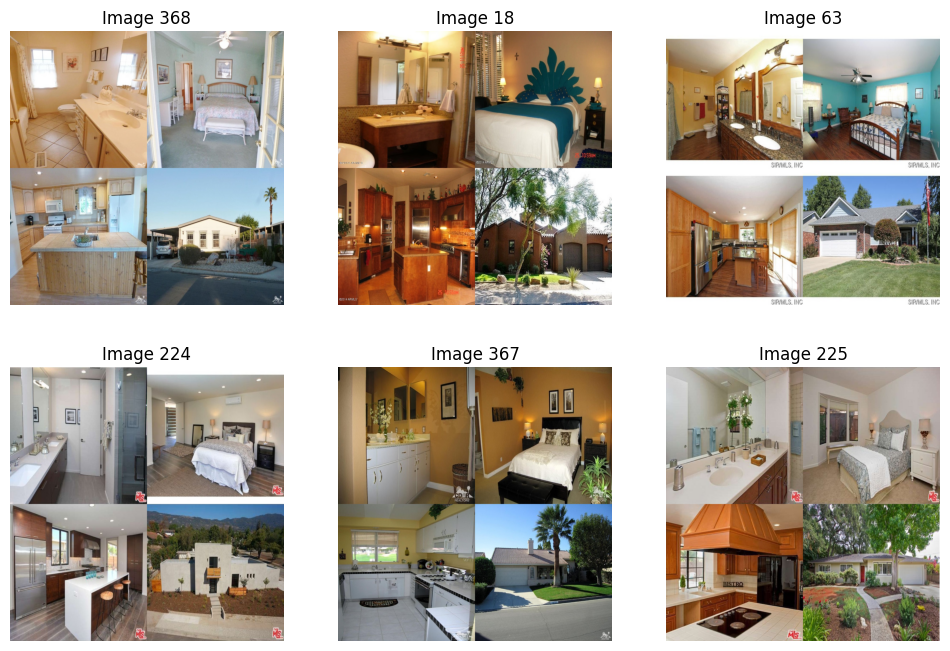

In [17]:
#inputPath = r'C:\Users\caspe\School\Semester 2\Deep learinig\Project\Test'
#inputPath = r'C:\Users\KaasT\Documents\Deep\Train'

# Assuming you have a list of available row_ids
available_row_ids = list(range(1,501))  # Update this with your actual data

# Choose 6 random row_ids
random_row_ids = random.sample(available_row_ids, 6)

# Create a subplot with 2 rows and 3 columns
plt.figure(figsize=(12, 8))
for i, row_id in enumerate(random_row_ids):
    plt.subplot(2, 3, i+1)
    image = get_image(row_id)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {row_id}")
    plt.axis('off')

plt.show()

Hier kunnen we zien dat de foto's van de huizen bestaan uit 4 verschillende onderdelen: Voordeur, Badkamer, Slaapkamer en keuken.

We maken een dataloader voor het efficient inladen van de data.

In [18]:
# Load images without considering the directory-generated labels
image_size = (1024, 1024)
batch_size = 5

# This loads the images but ignores the labels
image_dataset = tf.keras.utils.image_dataset_from_directory(
    inputPath,
    seed=123,
    label_mode=None,  # Ignore directory-based labels
    image_size=image_size,
    batch_size=batch_size
)


#Extract file paths from the dataset
image_file_paths = image_dataset.file_paths

# Extract only file ID without extension from file paths
image_uuids = [int(Path(image_file_path).stem) for image_file_path in image_file_paths]

# Map each file path to its label using the DataFrame
# Ensure the uuids in the DataFrame exactly match those in `image_uuids`
labels = [train.loc[train['House ID'] == uuid, 'Price'].values[0] for uuid in image_uuids]

# Convert the list of labels into a TensorFlow dataset
labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

# Combine the original image dataset with the labels dataset
final_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

# Split dataset into training and validation
train_ds = final_dataset.take(80) # Use 25 batches for training
val_ds = final_dataset.skip(80) # Use remaining batches for validation

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 500 files belonging to 1 classes.


In [19]:
# Define the input path where your test images are located
#test_inputPath = "/content/drive/MyDrive/verkoopprijzen-van-huizen-voorspellen/Test"

# Load test images without considering the directory-generated labels
test_image_dataset = tf.keras.utils.image_dataset_from_directory(
    test_inputPath,
    seed=123,
    label_mode=None,  # Ignore directory-generated labels
    image_size=image_size,
    batch_size=batch_size
)

# Cache, shuffle and prefetch the test dataset
test_ds = test_image_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 35 files belonging to 1 classes.


[to the top](#start)
<a name='data'></a>

<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: data mining</strong></h2>
</di

In [ ]:
geolocator = Nominatim(user_agent="http")

def cords_to_address(Latitude, Longitude):
    location = geolocator.reverse(Latitude+","+Longitude)

    address = location.raw['address']

    #city = address.get('city', '')
    #state = address.get('state', '')
    #country = address.get('country', '')
    #code = address.get('country_code')
    zipcode = address.get('postcode')

    return zipcode

In [ ]:
zip = pd.read_csv('zip.csv')
zip = zip[:-1]
zip = list(zip[' zip'].astype(int))

In [ ]:
zipcode_list = []
for i in range(len(train)):
    zipcode_list.append(zip[i])


train['zipcode'] = zipcode_list

zipcode_list = []
for i in range(len(test)):
    zipcode = str(cords_to_address(str(test['Latitude'][i]), str(test['Longitude'][i])))
    if zipcode == 'None':
        zipcode_list.append(0)
    else:
        zipcode_list.append(int(zipcode))

test['zipcode'] = zipcode_list

In [ ]:
train = train[train['zipcode'] != 0]
train

In [ ]:
pd.set_option('display.max_columns', None)

irs = pd.read_csv('IRS2016.csv')
irs

| VARIABLE NAME | DESCRIPTION                                             | VALUE/LINE REFERENCE                                      | Type |
|---------------|---------------------------------------------------------|-----------------------------------------------------------|------|
| STATEFIPS     | The State Federal Information Processing System (FIPS) code | 01-56                                                     | Char |
| STATE         | The State associated with the ZIP code                   | Two-digit State abbreviation code                         | Char |
| ZIPCODE       | 5-digit Zip code                                        |                                                           | Char |
| N1            | Number of returns                                       |                                                           | Num |
| MARS1         | Number of single returns                                | Filing status is single                                   | Num |
| MARS2         | Number of joint returns                                 | Filing status is married filing jointly                   | Num |
| MARS4         | Number of head of household returns                     | Filing status is head of household                         | Num |
| PREP          | Number of returns with paid preparer's signature         |                                                           | Num |
| N2            | Number of exemptions                                    | 1040:6d                                                   | Num |
| NUMDEP        | Number of dependents                                    | 1040:6c                                                   | Num |
| TOTAL_VITA    | Total number of volunteer prepared returns [3]          |                                                           | Num |
| VITA          | Number of volunteer income tax assistance (VITA) prepared returns [3] |                                                           | Num |
| TCE           | Number of tax counseling for the elderly (TCE) prepared returns [3] |                                                           | Num |
| VITA_EIC      | Number of volunteer prepared returns with Earned Income Credit [3] |                                                           | Num |
| RAL           | Number of refund anticipation loan returns              |                                                           | Num |
| RAC           | Number of refund anticipation check returns             |                                                           | Num |
| ELDERLY       | Number of elderly returns [4]                           |                                                           | Num |
| A00100        | Adjust gross income (AGI) [2]                            | 1040:37 / 1040A:21 / 1040EZ:4                              | Num |
| N02650        | Number of returns with total income                      | 1040:22 / 1040A:15 / 1040EZ:4                              | Num |
| A02650        | Total income amount                                     | 1040:22 / 1040A:15 / 1040EZ:4                              | Num |
| N00200        | Number of returns with salaries and wages                | 1040:7 / 1040A:7 / 1040EZ:1                                | Num |
| A00200        | Salaries and wages amount                               | 1040:7 / 1040A:7 / 1040EZ:1                                | Num |
| N00300        | Number of returns with taxable interest                 | 1040:8a / 1040A:8a / 1040EZ:2                             | Num |
| A00300        | Taxable interest amount                                 | 1040:8a / 1040A:8a / 1040EZ:2                             | Num |
| N00600        | Number of returns with ordinary dividends                | 1040:9a / 1040A:9a                                        | Num |
| A00600        | Ordinary dividends amount                                | 1040:9a / 1040A:9a                                        | Num |
| N00650        | Number of returns with qualified dividends               | 1040:9b / 1040A:9b                                        | Num |
| A00650        | Qualified dividends amount [5]                           | 1040:9b / 1040A:9b                                        | Num |
| N00700        | Number of returns with state and local income tax refunds | 1040:10                                                   | Num |
| A00700        | State and local income tax refunds amount                | 1040:10                                                   | Num |
| N00900        | Number of returns with business or professional net income (less loss) | 1040:12 | Num |
| A00900        | Business or professional net income (less loss) amount  | 1040:12                                                   | Num |
| N01000        | Number of returns with net capital gain (less loss)      | 1040:13  1040A:10                                        | Num |
| A01000        | Net capital gain (less loss) amount                      | 1040:13  1040A:10                                        | Num |
| N01400        | Number of returns with taxable individual retirement arrangements distributions | 1040:15b / 1040:11b | Num |
| A01400        | Taxable individual retirement arrangements distributions amount | 1040:15b / 1040:11b | Num |
| N01700        | Number of returns with taxable pensions and annuities    | 1040:16b / 1040A:12b                                     | Num |
| A01700        | Taxable pensions and annuities amount                   | 1040:16b / 1040A:12b                                     | Num |
| SCHF          | Number of farm returns                                   | 1040:18                                                   | Num |
| N02300        | Number of returns with unemployment compensation         | 1040:19 / 1040A:13 / 1040EZ:3                             | Num |
| A02300        | Unemployment compensation amount [6]                    | 1040:19 / 1040A:13 / 1040EZ:3                             | Num |
| N02500        | Number of returns with taxable Social Security benefits  | 1040:20b / 1040A:14b                                     | Num |
| A02500        | Taxable Social Security benefits amount                  | 1040:20b / 1040A:14b                                     | Num |
| N26270        | Number of returns with partnership/S-corp net income (less loss) | Schedule E:32                                          | Num |
| A26270        | Partnership/S-corp net income (less loss) amount         | Schedule E:32                                          | Num |
| N02900        | Number of returns with total statutory adjustments       | 1040:36 / 1040A:20                                       | Num |
| A02900        | Total statutory adjustments amount                       | 1040:36 / 1040A:20                                       | Num |
| N03220        | Number of returns with educator expenses                 | 1040:23 / 1040A:16                                       | Num |
| A03220        | Educator expenses amount                                 | 1040:23 / 1040A:16                                       | Num |
| N03300        | Number of returns with Self-employed (Keogh) retirement plans | 1040:28                                              | Num |
| A03300        | Self-employed (Keogh) retirement plans amount            | 1040:28                                              | Num |
| N03270        | Number of returns with Self-employed health insurance deduction | 1040:29                                      | Num |
| A03270        | Self-employed health insurance deduction amount          | 1040:29                                      | Num |
| N03150        | Number of returns with Individual retirement arrangement payments | 1040:32 / 1040A:17                              | Num |
| A03150        | Individual retirement arrangement payments amount       | 1040:32 / 1040A:17                              | Num |
| N03210        | Number of returns with student loan interest deduction   | 1040:33 / 1040A:18                              | Num |
| A03210        | Student loan interest deduction amount                   | 1040:33 / 1040A:18                              | Num |
| N03230        | Number of returns with tuition and fees deduction         | 1040:34 / 1040A:19                              | Num |
| A03230        | Tuition and fees deduction amount                         | 1040:34 / 1040A:19                              | Num |
| N03240        | Returns with domestic production activities deduction    | 1040:35                                      | Num |
| A03240        | Domestic production activities deduction amount         | 1040:35                                      | Num |
| N04470        | Number of returns with itemized deductions                | 1040:40                                      | Num |
| A04470        | Total itemized deductions amount                          | 1040:40                                      | Num |
| A00101        | Amount of AGI for itemized returns                        | 1040:37                                      | Num |
| N17000        | Number of returns with Total medical and dental expense deduction | Schedule A:4                              | Num |
| A17000        | Total medical and dental expense deduction amount        | Schedule A:4                              | Num |
| N18425        | Number of returns with State and local income taxes       | Schedule A:5a                               | Num |
| A18425        | State and local income taxes amount                        | Schedule A:5a                               | Num |
| N18450        | Number of returns with State and local general sales tax  | Schedule A:5b                               | Num |
| A18450        | State and local general sales tax amount                   | Schedule A:5b                               | Num |
| N18500        | Number of returns with real estate taxes                  | Schedule A:6                                | Num |
| A18500        | Real estate taxes amount                                  | Schedule A:6                                | Num |
| N18800        | Number of returns with Personal property taxes            | Schedule A:7                                | Num |
| A18800        | Personal property taxes amount                            | Schedule A:7                                | Num |
| N19300        | Number of returns with Home mortgage interest paid        | Schedule A:10                               | Num |
| A19300        | Home mortgage interest paid amount                        | Schedule A:10                               | Num |
| N19500        | Number of returns with Home mortgage from personal seller | Schedule A:11                               | Num |
| A19500        | Home mortgage from personal seller amount                 | Schedule A:11                               | Num |
| N19530        | Number of returns with Deductible points                  | Schedule A:12                               | Num |
| A19530        | Deductible points amount                                  | Schedule A:12                               | Num |
| N19550        | Number of returns with Qualified Mortgage Insurance premiums | Schedule A:13                           | Num |
| A19550        | Qualified Mortgage Insurance premiums amount              | Schedule A:13                           | Num |
| N19570        | Number of returns with Investment interest paid           | Schedule A:14                            | Num |
| A19570        | Investment interest paid amount                           | Schedule A:14                            | Num |
| N19700        | Number of returns with Total charitable contributions     | Schedule A:19                           | Num |
| A19700        | Total charitable contributions amount                     | Schedule A:19                           | Num |
| N20800        | Number of returns with Net limited miscellaneous deduction | Schedule A:27                          | Num |
| A20800        | Net limited miscellaneous deduction amount                 | Schedule A:27                          | Num |
| N21020        | Number of returns with Other non-limited miscellaneous deduction | Schedule A:28                   | Num |
| A21020        | Other non-limited miscellaneous deduction amount            | Schedule A:28                   | Num |
| N04800        | Number of returns with taxable income                      | 1040:43 / 1040A:27 / 1040EZ:6          | Num |
| A04800        | Taxable income amount                                      | 1040:43 / 1040A:27 / 1040EZ:6          | Num |
| N05800        | Number of returns with income tax before credits           | 1040:47 / 1040A:30 / 1040EZ:10         | Num |
| A05800        | Income tax before credits amount                           | 1040:47 / 1040A:30 / 1040EZ:10         | Num |
| N09600        | Number of returns with alternative minimum tax             | 1040:45                              | Num |
| A09600        | Alternative minimum tax amount                               | 1040:45                              | Num |
| N05780        | Number of returns with excess advance premium tax credit repayment | 1040:46/ 1040A:29         | Num |
| A05780        | Excess advance premium tax credit repayment amount         | 1040:46/ 1040A:29         | Num |
| N07100        | Number of returns with total tax credits                     | 1040:55 / 1040A:36               | Num |
| A07100        | Total tax credits amount                                     | 1040:55 / 1040A:36               | Num |
| N07300        | Number of returns with foreign tax credit                    | 1040:48                        | Num |
| A07300        | Foreign tax credit amount                                    | 1040:48                        | Num |
| N07180        | Number of returns with child and dependent care credit      | 1040:49 / 1040A:31             | Num |
| A07180        | Child and dependent care credit amount                        | 1040:49 / 1040A:31             | Num |
| N07230        | Number of returns with nonrefundable education credit        | 1040:50 / 1040A:33             | Num |
| A07230        | Nonrefundable education credit amount                        | 1040:50 / 1040A:33             | Num |
| N07240        | Number of returns with retirement savings contribution credit | 1040:51 / 1040A:34           | Num |
| A07240        | Retirement savings contribution credit amount                | 1040:51 / 1040A:34           | Num |
| A07220 | Child tax credit amount                                | 1040:52 / 1040A:35                       | Num  |
| N07260 | Number of returns with residential energy tax credit    | 1040:53                                  | Num  |
| A07260 | Residential energy tax credit amount                    | 1040:53                                  | Num  |
| N09400 | Number of returns with self-employment tax              | 1040:57                                  | Num  |
| A09400 | Self-employment tax amount                              | 1040:57                                  | Num  |
| N85770 | Number of returns with total premium tax credit         | 8962:24                                  | Num  |
| A85770 | Total premium tax credit amount                         | 8962:24                                  | Num  |
| N85775 | Number of returns with advance premium tax credit        | 8962:25                                  | Num  |
| A85775 | Advance premium tax credit amount                       | 8962:25                                  | Num  |
| N09750 | Number of returns with health care individual responsibility payment | 1040:61 / 1040A:38 / 1040EZ:11 | Num  |
| A09750 | Health care individual responsibility payment amount   | 1040:61 / 1040A:38 / 1040EZ:11           | Num  |
| N10600 | Number of returns with total tax payments               | 1040:74 / 1040A:46 / 1040EZ:9            | Num  |
| A10600 | Total tax payments amount                               | 1040:74 / 1040A:46 / 1040EZ:9            | Num  |
| N59660 | Number of returns with earned income credit             | 1040:66a / 1040A:42a / 1040EZ:8a        | Num  |
| A59660 | Earned income credit amount                          | 1040:66a / 1040A:42a / 1040EZ:8a        | Num  |
| N59720 | Number of returns with excess earned income credit      | 1040:66a / 1040A:42a / 1040EZ:8a        | Num  |
| A59720 | Excess earned income credit (refundable) amount     | 1040:66a / 1040A:42a / 1040EZ:8a        | Num  |
| N11070 | Number of returns with additional child tax credit      | 1040:67 / 1040A:43                       | Num  |
| A11070 | Additional child tax credit amount                      | 1040:67 / 1040A:43                       | Num  |
| N10960 | Number of returns with refundable education credit      | 1040:68 / 1040A:44                       | Num  |
| A10960 | Refundable education credit amount                      | 1040:68 / 1040A:44                       | Num  |
| N11560 | Number of returns with net premium tax credit           | 1040:69 / 1040A:45                       | Num  |
| A11560 | Net premium tax credit amount                           | 1040:69 / 1040A:45                       | Num  |
| N06500 | Number of returns with income tax                       | 1040:56 / 1040A:37 / 1040EZ:10           | Num  |
| A06500 | Income tax amount                                  | 1040:56 / 1040A:37 / 1040EZ:10           | Num  |
| N10300 | Number of returns with tax liability                    | 1040:63 / 1040A:39 / 1040EZ: 10          | Num  |
| A10300 | Total tax liability amount                         | 1040:63 / 1040A:39 / 1040EZ: 10          | Num  |
| N85530 | Number of returns with additional Medicare tax          | 1040:62a                                | Num  |
| A85530 | Additional Medicare tax amount                          | 1040:62a                                | Num  |
| N85300 | Number of returns with net investment income tax         | 1040:62b                                | Num  |
| A85300 | Net investment income tax amount                        | 1040:62b                                | Num  |
| N11901 | Number of returns with tax due at time of filing         | 1040:78 / 1040A:50 / 1040EZ:14           | Num  |
| A11901 | Tax due at time of filing amount                   | 1040:78 / 1040A:50 / 1040EZ:14           | Num  |
| N11902 | Number of returns with overpayments refunded            | 1040:75 / 1040A:47 / 1040EZ:13a          | Num  |
| A11902 | Overpayments refunded amount                     | 1040:75 / 1040A:47 / 1040EZ:13a          | Num  |






In [ ]:
test_irs = pd.merge(test, irs, left_on='zipcode', right_on='ZIPCODE', how='left')
test_irs = test_irs.drop(columns=['House ID','Latitude','Longitude','zipcode','STATEFIPS','STATE','ZIPCODE','AGI_STUB'])


train_irs = pd.merge(train, irs, left_on='zipcode', right_on='ZIPCODE', how='left')
train_irs = train_irs.drop(columns=['House ID','Latitude','Longitude','zipcode','STATEFIPS','STATE','ZIPCODE','AGI_STUB'])
train_irs = train_irs.dropna()
test_irs

[Back to the top](#start)
<a name='dense'></a>

<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: Fully-connected neuraal netwerk</strong></h2>
</div>


### &sect;3.1: Fully-connected neuraal netwerk (Dense model)
- [x] Model correct gebouwd (2 punten)


In [ ]:
y_nn = train_irs['Price']
X_nn = train_irs.drop(['Price'], axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler


temp = pd.concat([pd.DataFrame(X_nn), pd.DataFrame(test_irs)], axis=0, ignore_index=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(temp)

X_scaled = scaled_data[:len(X_nn)]
test_irs_scaled = scaled_data[len(X_nn):]

In [ ]:
## from keras.callbacks import EarlyStopping
from keras.losses import MeanAbsolutePercentageError
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

model = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(146,), activation='relu'),
    BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    BatchNormalization(),
    keras.layers.Dense(1, activation='linear')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='MeanAbsolutePercentageError', metrics=['RootMeanSquaredError'])

early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True, verbose=1)

history = model.fit(X_train, y_train, epochs=6500, validation_data=(X_val, y_val), callbacks=[early_stopping], batch_size=25)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [ ]:
y_pred = model.predict(test_irs_scaled)
y_pred

yes zijn de echte prijzen van test voor kaggle hiermee kunnen we testen of het model klopt op de testset zonder continu naar kaggle te uploaden.

In [22]:
yes = [599900, 344900, 309995, 572000, 695000, 525000, 78000, 424900, 825000, 475000, 850000, 409900, 540000, 385000, 195000, 458000, 468000, 458000, 389000, 460000, 430000, 329900, 349900, 454999, 569950, 525000, 380000, 550000, 449950, 495000, 399900, 460000, 407000, 419000, 615000]

In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
      """
    Bereken de gemiddelde absolute percentagefout (MAPE) tussen de werkelijke waarden en voorspelde waarden.

    Parameters:
        y_true : Array of werkelijke waarden.
        y_pred : Array of voorspelde waarden.

    Returns:
        float: De MAPE-waarde als een float.

    Raises:
        ValueError: Wanneer y_true en y_pred niet dezelfde lengte hebben.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Ensure there are no zeros in the denominator to avoid division by zero
    mask = y_true != 0

    # Calculate absolute percentage error for each data point
    ape = np.abs((y_true - y_pred) / y_true) * 100

    # Take the mean of absolute percentage errors, ignoring those with zero in the denominator
    mape = np.mean(ape[mask])

    return mape

mape = mean_absolute_percentage_error(yes, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


NameError: name 'yes' is not defined

In [ ]:
#csv_file_path = r'D:\Jaspe\ADS_Ai_2\Deeplearning_cv\DL_Portfolio\verkoopprijzen-van-huizen-voorspellen\Models\lr.csv'
csv_file_path = r'C:\Users\KaasT\Documents\Deep\voorspellingen\1303_1201.csv'
#parameters
h_id_values = test['House ID'] # niet veranderen
predictions_values = y_pred #predictions van model

# push functie toepassen
push_dataframe(h_id_values, predictions_values, push=True, csv_file_path=csv_file_path)

[Back to the top](#start)
<a name='dense-architecture'></a>
<h3>&sect;3.2: Modelarchitectuur en onderbouwing</h3>

- [x] Keuze en onderbouwing hyperparameters (6 punten)
- [x] Modelarchitectuur gevisualiseerd (1 punt)
- [x] Correcte lossfunctie geselecteerd en keuzes uitgelegd (4 punten)
- [ ] Uitleg keuze van optimizer en beschrijving van optimizer (4 punten)
- [x] Juiste data gebruikt (1 punt)
- [x] Model gecompileerd en getraind, keuze van aantal epochs uitgelegd (2 punten)



**hyperparameters**

We hebben 5 dense layers gebruikt. Het aantal neuronen per laag: 1024, 2 keer 512 en 64 neuronen.

Activatiefunctie: De activatiefunctie bepaalt de output van een neuron gegeven een input. Hier wordt de ReLU (Rectified Linear Activation) functie gebruikt voor de meeste lagen ('relu'). ReLU wordt vaak gebruikt vanwege snelle training en vermijden van het probleem van verdwijnende gradiënten. De laatste laag gebruikt een lineaire activatiefunctie ('linear').

Batch Normalization: Batch Normalization is een techniek die helpt bij het stabiliseren en versnellen van het trainingsproces door het normaliseren van de input van elke laag. Het wordt gebruikt na elke Dense laag in dit model.

Optimizer: De optimizer bepaalt hoe de parameters van het model worden bijgewerkt tijdens het trainen om de loss-functie te minimaliseren.  Hier wordt de Adam optimizer gebruikt met een leersnelheid van 0.001. Dit is de Default learningrate van Adam.

#### lossfunctie

Voor de loss functie hebben wij de mean absolute percentage error gebruikt. De mean absolute percentage error (afgekort MAPE) is niet afhankelijk van de schaal van de data. Verder is MAPE ook makkelijk te interpreteren, omdat het een percentage geeft. Dit is duidelijker omdat de schaal van de error gelijk te zien is, in tegenstelling tot bijvoorbeeld mean absolute error.



#### aantal epochs

In dit geval hebben we gekozen voor 6500 epochs met earlystopping patience van 500. Dit zorgt ervoor dat niet alle epochs perse worden gerund. we hebben gekozen voor zoveel epochs en een hoge patience omdat de loss_val na grote aantallen epochs meer leert.

In [ ]:
keras.utils.plot_model(model)
model.summary()

[Back to the top](#start)
<a name='cnn'></a>

<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: Convolutioneel neuraal netwerk (CNN</strong></h2>
</div>

### &sect;4.1: Convolutioneel neuraal netwerk (CNN)
- [ ] CNN model correct gebouwd (2 punten)


Epoch 1/100
80/80 [==============================] - 48s 580ms/step - loss: 99.8242 - mape: 99.8242 - val_loss: 99.3536 - val_mape: 99.3536
Epoch 2/100
80/80 [==============================] - 5s 68ms/step - loss: 98.7237 - mape: 98.7237 - val_loss: 96.7653 - val_mape: 96.7653
Epoch 3/100
80/80 [==============================] - 5s 65ms/step - loss: 92.3591 - mape: 92.3591 - val_loss: 79.8333 - val_mape: 79.8333
Epoch 4/100
80/80 [==============================] - 5s 65ms/step - loss: 74.1331 - mape: 74.1331 - val_loss: 69.7756 - val_mape: 69.7756
Epoch 5/100
80/80 [==============================] - 5s 66ms/step - loss: 71.6877 - mape: 71.6877 - val_loss: 69.6196 - val_mape: 69.6196
Epoch 6/100
80/80 [==============================] - 5s 67ms/step - loss: 71.5978 - mape: 71.5978 - val_loss: 69.5690 - val_mape: 69.5690
Epoch 7/100
80/80 [==============================] - 5s 65ms/step - loss: 71.6167 - mape: 71.6167 - val_loss: 69.5316 - val_mape: 69.5316
Epoch 8/100
80/80 [=============

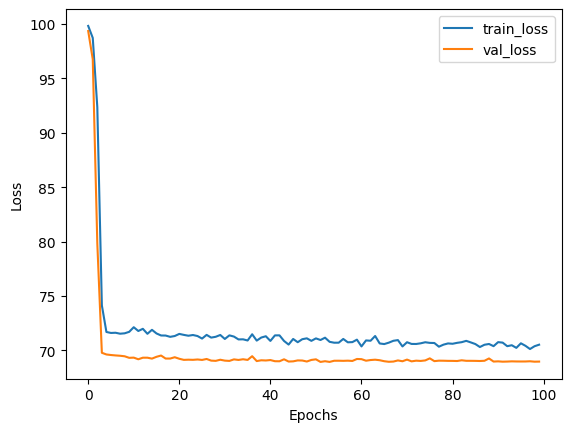

In [25]:
def create_regression_cnn(input_shape):
    model = keras.models.Sequential([
        keras.layers.Input(input_shape),
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.2),
        # Convolutional layers
        keras.layers.Conv2D(3, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),


        # Dense layers
        keras.layers.Flatten(),
        keras.layers.Dense(96, activation='relu'),
        keras.layers.Dense(1)  # Output layer for regression (1 neuron for single output value)
        ])

    return model

# Example usage
input_shape = (1024, 1024, 3)  # Input shape of your images

# Create the regression CNN model
model = create_regression_cnn(input_shape)

# Compile the model for regression
model.compile(optimizer=keras.optimizers.Adam(learning_rate=4e-5),
              loss='mean_absolute_percentage_error',  # Use mean squared error loss for regression
              metrics=['mape'])

top_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(train_ds, validation_data=val_ds, epochs=100)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a name='cnn-hyperparameters'></a>
### &sect;4.2: Modelarchitectuur en onderbouwing
- [x] Keuze en onderbouwing hyperparameters (6 punten)
- [x] Regularisatie of dropout of batchnorm toegepast en uitgelegd (4 punten)
- [x] Modelarchitectuur gevisualiseerd (1 punt)
- [x] Model gecompileerd en getraind, keuze van aantal epochs uitgelegd (2 punten)

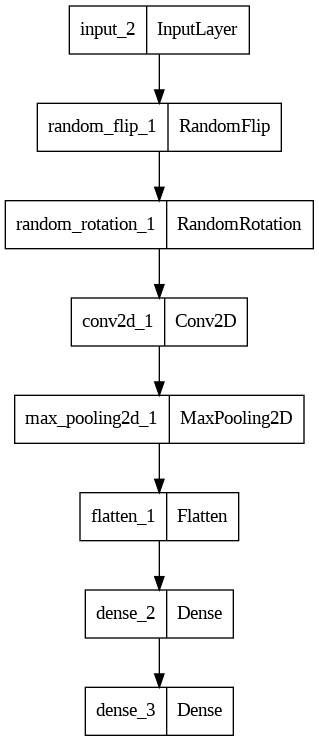

In [28]:
keras.utils.plot_model(model)

Voor het kiezen van de juiste hyperparameters hebben we een grondige gridsearch in meerdere delen uitgevoerd, hierin hebben we getest:

 - Convolutional en maxpooling layers: (1,2,3,4)
 - Dropout: (min=0,max=0.5,step=0.1)
 - BatchNormalization: (0,1)
 - Dense layers: (1,2,3)
 - Dense layer neurons:(min=32, max=512, step=32)
 - Adam learningrate: [1e-2, 1e-3, 1e-4,1e-5,4e-5]
 - regulizers: (None,l1,l2,l1_l2)

 Voor het kiezen van het correcte aantal epochs om overfitting en underfitting te voorkomen maken we gebruik van earlystopping. Dit zorgd ervoor dat het model door blijft trainen tot het geen beter resultaat meer krijgt waarna het dan stopt.

**Dropout** is een populaire regularisatietechniek om overfitting te verminderen door willekeurig geselecteerde neuronen uit te schakelen tijdens de training.Door dit te doen vermindert dropout de onderlinge afhankelijkheid tussen neuronen.

**BatchNormalization**
 Batch normalization is een techniek die vaak wordt gebruikt om het trainingsproces te versnellen en de stabiliteit van het model te verbeteren. Het doel van batch normalization is om de activaties in elke laag van het netwerk te normaliseren door ze te Scalen.

**L1** ook wel "Lasso regularization" genoemd, voegt een term toe aan de loss functie op basis van de absolute waarden van de gewichten, die de gewichten naar nul duwd.

**L2** staat voor "Ridge regularization". Het is gerelateerd aan het idee van Ridge-regressie uit de lineaire regressie, waarbij de kwadratische waarden van de gewichten worden toegevoegd aan de loss functie. Deze aanpak wordt vaak gebruikt om overfitting te verminderen door de grootte van de gewichten te beperken.

Uit de gridsearch (keras_tuner) zijn de volgende resultaten gekomen:

 - Convolutional en maxpooling layers: (1)
 - Convolutional filters: (3)
 - Dropout: (0)
 - BatchNormalization: (0)
 - Dense layers: (1)
 - Dense layer neurons:(96)
 - Adam learningrate: (4e-5)
 - regulizers: (None)



[Back to the top](#start)
<a name='transfer-learning'></a>

<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5:Transfer learning</strong></h2>
</div>

### &sect;5.1: Transfer learning
- [ ] Transfer-learning model correct gebouwd (2 punten)


In [26]:
input_shape = (1024, 1024, 3)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

transfer_model = Sequential([
    base_model,
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])


# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
transfer_model.compile(optimizer=opt, loss='mape')

# Train the model
history = transfer_model.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=[early_stopping])


9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/1000
80/80 [==============================] - 28s 259ms/step - loss: 98.9261 - val_loss: 97.6468
Epoch 2/1000
80/80 [==============================] - 17s 216ms/step - loss: 96.1954 - val_loss: 94.6541
Epoch 3/1000
80/80 [==============================] - 17s 213ms/step - loss: 93.1137 - val_loss: 91.2512
Epoch 4/1000
80/80 [==============================] - 17s 212ms/step - loss: 89.7237 - val_loss: 87.5991
Epoch 5/1000
80/80 [==============================] - 20s 245ms/step - loss: 86.2114 - val_loss: 83.4949
Epoch 6/1000
80/80 [==============================] - 17s 211ms/step - loss: 82.5257 - val_loss: 79.4864
Epoch 7/1000
80/80 [==============================] - 17s 215ms/step - loss: 78.8142 - val_loss: 75.9730
Epoch 8/1000
80/80 [==============================] - 17s 211ms/step - loss: 75.2464 - val_loss: 73.7967
Epoch 9/1000
80/80 [==============================] - 17s 211ms/step - loss: 73.7220 - val_loss: 

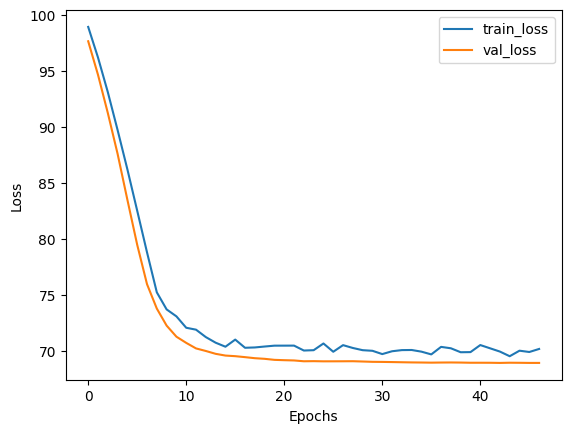

In [30]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a name='tl-pretrained'></a>
### &sect;5.2: Pretrained model en voordelen
- [ ] Pretrained model benoemd en voordelen uitgelegd (4 punten)
- [ ] Keuze en onderbouwing hyperparameters (6 punten)


**Batch Normalization (BatchNormalization):**
Deze laag normaliseert de activaties van elke laag in een neuronaal netwerk, waardoor het trainen sneller en stabiel wordt. Het helpt bij het voorkomen van interne covariatieverschuivingen en versnelt daarmee het trainingsproces.

**ReLU (Rectified Linear Unit):**
ReLU is een activatiefunctie die veel wordt gebruikt in neurale netwerken. Het vervangt negatieve waarden door nul en laat positieve waarden ongewijzigd. Het toevoegen van niet-lineariteit helpt bij het leren van complexe functies door het model.

**Convolutional 2D (Conv2D):**
Dit is een convolutielaag die wordt gebruikt voor het uitvoeren van convolutiebewerkingen op de invoer, waarbij filters worden toegepast om kenmerken te extraheren uit het beeld. Het wordt vaak gevolgd door een ReLU-activatiefunctie om niet-lineariteit toe te voegen.

**Depthwise Separable Convolution 2D (DepthwiseConv2D):**
Deze laag bestaat uit twee afzonderlijke stappen: eerst wordt convolutie toegepast op elk kanaal van de invoer (depthwise convolutie), gevolgd door een puntsgewijze convolutie (1x1 convolutie) om de kenmerken te combineren. Het helpt bij het verminderen van het aantal parameters en het verbeteren van de efficiëntie van het model.

**Addition (Add):**
Deze laag wordt soms toegevoegd in residuale verbindingen om de oorspronkelijke invoer toe te voegen aan de uitvoer van een reeks convolutielagen. Dit helpt bij het verminderen van het verdwijnen van gradiënten tijdens het trainen en draagt bij aan een stabielere training van diepe neurale netwerken.

**De structuur** van MobileNetV2 is gebaseerd op een combinatie van Depthwise Separable Convolution en residuale verbindingen. Dit maakt het model lichter en efficiënter in vergelijking met traditionele convolutionele neurale netwerken. Het bestaat uit verschillende bouwstenen, zoals de 'bottleneck'-bouwblokken, die bestaan uit een sequentie van Depthwise Convolution, Batch Normalization, ReLU en Pointwise Convolution. Deze bouwblokken worden vervolgens herhaaldelijk gestapeld om een dieper en krachtiger model te creëren. Overall, MobileNetV2 bereikt een goede balans tussen nauwkeurigheid en rekenkundige efficiëntie, waardoor het geschikt is voor toepassingen op mobiele apparaten en embedded systemen.


https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/


Door middel van Keras-Tuner hebben we gekeken bij welke waarde we de beste scoren krijgen. Hiermee hebben we gevonden dat een dense layer van 128, een dropout van 0.3 en een learningrate van 0.0001 het beste is. We hebben getest voor Dens: min_value=64, max_value=194, step=64. Voor Dropout: min_value=0.2, max_value=0.5, step=0.1. LearningRate: values=[1e-2, 1e-3, 1e-4]. We hebben gekozen voor niet meer dan 194 neurons in de Dense layer omdat het model dan te lang bezig is met runnen.

<a name='tl-hyperparameters'></a>
### &sect;5.3:  Modelarchitectuur, Keuze en onderbouwing
- [x] Modelarchitectuur gevisualiseerd (1 punt)
- [x] Transfer-learning stappen toegelicht (4 punten)
- [x] Juiste data gebruikt (1 punt)
- [x] Model gecompileerd en getraind, keuze van aantal epochs uitgelegd (2 punten)

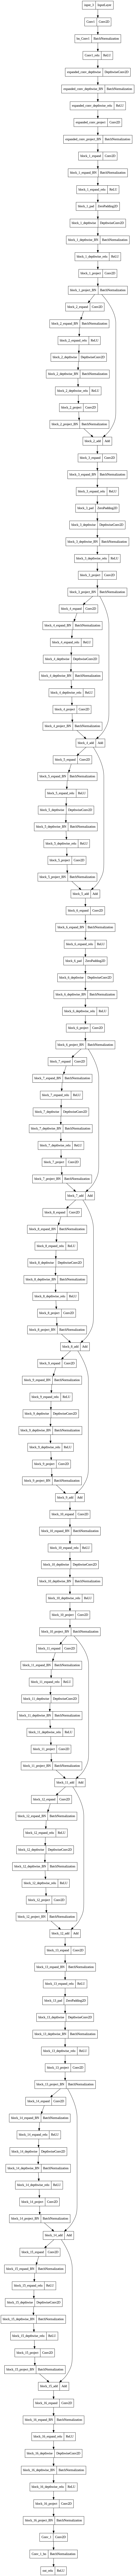

In [31]:
plot_model(base_model)

MobileNetV2 wordt gebruikt als het vooraf getrainde model. Dit is gunstig vanwege zijn efficiëntie en hoge prestaties, met name op mobiele apparaten. Het voordeel van het gebruik van een vooraf getraind model zoals MobileNetV2 is dat het al is getraind op een groot en gevarieerd dataset, waardoor het bepaalde visuele concepten kan generaliseren en leren. Door deze voorgetrainde gewichten te gebruiken als startpunt, profiteer je van deze aangeleerde representaties, wat vaak leidt tot betere prestaties, vooral bij beperkte gegevens.

De stappen die je moet volgen voor transferlearning is als volgt:

- Eerst moet je je gekozen model downloaden en aanmaken. Hiermee is het handig je de goede input_shape gebruikt zodat het het-  beste past bij jouw eigen werking.

- Tweede stap is om ervoor te zorgen dat je de al aangemaakte model niet opnieuw gaat trainen. Dit doe je door de layers van MobileNetV2 trainen als False te zetten. Hierdoor gebruikt het de opgeslagen gewichten. Waardoor het model beter gaat presenteren. Want deze gewichten zijn al geoptimaliseerd.

- Als laatst moet je wel de laatset layers aanpassen en trainen. Dit doe je door een nieuwe Dense layers toe tevoegen waarmee je uiteindelijk de voorspelling doet voor wat jij wilt hebben. Deze lagen moet je wel nog eest trainen

We hebben gekozen voor 1000 epochs en een earlystopping met een patience van 4. Waardoor we zeker weten dat we niet te vroeg stoppen.

In [ ]:
y_pred = transfer_model.predict(test_ds)
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


In [ ]:
#csv_file_path = r'D:\Jaspe\ADS_Ai_2\Deeplearning_cv\DL_Portfolio\verkoopprijzen-van-huizen-voorspellen\Models\lr.csv'
csv_file_path = r'C:\Users\KaasT\Documents\Deep\voorspellingen\1303_1201.csv'
#parameters
h_id_values = test['House ID'] # niet veranderen
predictions_values = y_pred #predictions van model

# push functie toepassen
push_dataframe(h_id_values, predictions_values, push=True, csv_file_path=csv_file_path)

[Back to the top](#start)
<a name='multimodal'></a>

<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H6: Multimodaal model</strong></h2>
</div>

### &sect;6.1: Multimodaal model
- [ ] Model correct gebouwd met twee takken (5 punten)


Dataloader voor multimodaal model

In [ ]:
# Load images without considering the directory-generated labels
image_size = (1024, 1024)
batch_size = 5

# This loads the images but ignores the labels
image_dataset = tf.keras.utils.image_dataset_from_directory(
    inputPath,
    seed=123,
    label_mode=None,  # Ignore directory-based labels
    image_size=image_size,
    batch_size=batch_size
)


#Extract file paths from the dataset
image_file_paths = image_dataset.file_paths

# Extract only file ID without extension from file paths
image_uuids = [int(Path(image_file_path).stem) for image_file_path in image_file_paths]

# Map each file path to its tabular features using the DataFrame
# Ensure the uuids in the DataFrame exactly match those in `image_uuids`
tabular_column_names = list(train_irs.columns)
tabular_column_names.remove('House ID')
tabular_column_names.remove('Price')
tabular_features = [train_irs.loc[train_irs['House ID'] == uuid, tabular_column_names].values[0] for uuid in image_uuids]

# Convert the list of tabular features into a TensorFlow dataset
tabular_features_dataset = tf.data.Dataset.from_tensor_slices(tabular_features).batch(batch_size)

# Map each file path to its label using the DataFrame
# Ensure the uuids in the DataFrame exactly match those in `image_uuids`
labels = [train_irs.loc[train_irs['House ID'] == uuid, 'Price'].values[0] for uuid in image_uuids]


# Convert the list of labels into a TensorFlow dataset
labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

# Combine the original image dataset with the labels dataset
final_dataset = tf.data.Dataset.zip((image_dataset, tabular_features_dataset), labels_dataset)


# Split dataset into training and validation
train_ds = final_dataset.take(80) # Use 25 batches for training
val_ds = final_dataset.skip(80) # Use remaining batches for validation

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Branch 1: Image Input
img_input = keras.layers.Input(shape=(1024, 1024, 3), name='img_input')
x1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(img_input)
x1 = keras.layers.MaxPooling2D((2, 2))(x1)
x1 = keras.layers. Conv2D(64, (3, 3), activation='relu')(x1)
x1 = keras.layers.MaxPooling2D((2, 2))(x1)
x1 = keras.layers.Conv2D(128, (3, 3), activation='relu')(x1)
x1 = keras.layers.MaxPooling2D((2, 2))(x1)
x1 = Flatten()(x1)

# Branch 2: Tabular Data Input
tab_input = Input(shape=(146,), name='tab_input')
x2 = keras.layers.Dense(1024, activation='relu')(tab_input)
x2 = BatchNormalization()(x2)
x2 = keras.layers.Dense(512, activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = keras.layers.Dense(512, activation='relu')(x2)
x2 = BatchNormalization()(x2)

# Concatenate the two branches
concatenated = concatenate([x1, x2])

# Additional Dense layers after concatenation
x = Dense(256, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

# Output layer
output = Dense(1, activation='linear')(x)

# Create the model
model = Model(inputs=[img_input, tab_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='MeanAbsolutePercentageError', metrics=['RootMeanSquaredError'])

keras.utils.plot_model(model)

In [ ]:
num_epochs = 2


history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)

<a name='mm-hyperparameters'></a>
### &sect;6.2: Modelarchitectuur, Keuze en onderbouwing hyperparameters en strategie
- [ ] Keuze en onderbouwing hyperparameters en strategie (10 punten)
- [x] Modelarchitectuur gevisualiseerd (1 punt)
- [x] Juiste data gebruikt (2 punten)
- [ ] Model gecompileerd en getraind, keuze van aantal epochs uitgelegd (2 punten)


Onze strategie was om eerst afzonderlijk een goed neuraal netwerk (NN) en een convolutioneel neuraal netwerk (CNN) te trainen voordat we ze samenvoegden. We hebben gekozen voor een klein aantal trainingsepoches om aan te tonen dat het model effectief werkt\.

[Back to the top](#findings)
<a name='Bevindingen'></a>

<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H7: Bevindingen</strong></h2>
</div>

### &sect;7.1: Resultaten
- [x] Overzicht van resultaten (3 punten)


## Kaggle scores:
 - artificial Neural Network     : 0.3859
 - Convolutional Neural Network  : 0.71
 - Transfer model                : 1.00
 - Multimodel                    : 0.99

<a name='findings-best-model'></a>
### &sect;7.2: Best presterende model
- [x] Beschrijving en overzicht van het best presterende model (2 punten)

In [27]:
# Artificia Neural Network
"""model = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(146,), activation='relu'),
    BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    BatchNormalization(),
    keras.layers.Dense(1, activation='linear')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='MeanAbsolutePercentageError',
              metrics=['RootMeanSquaredError'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=500,
                               restore_best_weights=True,
                               verbose=1)

history = model.fit(X_train,
                    y_train,
                    epochs=6500,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    batch_size=25)

"""

"model = keras.Sequential([\n    keras.layers.Dense(1024, input_shape=(146,), activation='relu'),\n    BatchNormalization(),\n    keras.layers.Dense(512, activation='relu'),\n    BatchNormalization(),\n    keras.layers.Dense(512, activation='relu'),\n    BatchNormalization(),\n    keras.layers.Dense(64, activation='relu'),\n    BatchNormalization(),\n    keras.layers.Dense(1, activation='linear')\n])\n\noptimizer = keras.optimizers.Adam(learning_rate=0.001)\n\nmodel.compile(optimizer=optimizer,\n              loss='MeanAbsolutePercentageError',\n              metrics=['RootMeanSquaredError'])\n\nearly_stopping = EarlyStopping(monitor='val_loss',\n                               patience=500,\n                               restore_best_weights=True,\n                               verbose=1)\n\nhistory = model.fit(X_train,\n                    y_train,\n                    epochs=6500,\n                    validation_data=(X_val, y_val),\n                    callbacks=[early_stopping],\

[Back to the top](#start)
<a name='conclusion'></a>

<div style="background-color:#009090; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H8: Conclusie en aanbevelingen</strong></h2>
</div>

### &sect;8.1: Samenvatting van modeleringsproces
- [x] Samenvatting van modeleringsproces (2 punten)



Tijdens het modelerings proces liepen we vaak tegen de limieten van onze eigen laptops aan,
zoals te weinig RAM en een langzaam trainings proces. Ook bij gebruik van google colab hadden we moeite met deze limieten
en hebben we geleerd om met veel efficientere dataloaders te werken. Hiermee was het probleem van te weinig Ram opgelost en
konden we de google.colab gpu gebruiken voor snellere trainingstijden.

Zelfs met deze efficientere oplossingen koste het tunen van de juiste hyperparameters teveel tijd en moesten we deze in
meerdere stukken hakken.


Wat opviel was dat de modellen die werkten met tabular data, betere mape scores gaven(NN:0.38) en de modellen met image data niet beter werkten dan een mape van 0.69.

<a name='conclusion-findings'></a>
### &sect;8.2: Conclusie
- [x] Conclusie gebaseerd op bevindingen (5 punten)


Bij het werken met video en foto data is het essentieel om gebruik te maken van een slimme data pipeline technieken zoals een dataloader. En voor complexere deeplearning modellen waar veel berekeningen worden gedaan is een goed werkende gpu belangrijk om tijd te besparen. Daarnaast om tijd en ruimte te besparen is het mogelijk ervoor te kiezen om de image data kleiner te maken door grayscaling of de resolutie te verlagen.


De prijs is niet alleen gebonden aan hoe het huis eruit ziet zoals op het plaatje maar ook sterk aan de locatie. Zoals in de stad of aan zee.




<a name='conclusion-recommendations'></a>
### &sect;8.3: Aanbeveling
- [x] Aanbeveling sluit aan op conclusie (3 punten)

**Advies Makelaar:**\
Welk advies kun je op basis hiervan geven aan een makelaar?
Ookal speelt de grote van het huis een grote factor,

**Advies huizenkopers:**\
Als je een goedkoper groot huis wilt kun je beter op een minder gewilde locatie kiezen zoeals buiten de stad.

### bronnen
 - Educative. (z.d.). Keras dropout layer: implement regularization. https://www.educative.io/answers/keras-dropout-layer-implement-regularization
 - Wikipedia contributors. (2024, 6 februari). Batch normalization. Wikipedia. https://en.wikipedia.org/wiki/Batch_normalization
 -  Nagpal, A. (2022, 5 januari). L1 and L2 Regularization Methods, Explained. Built In. https://builtin.com/data-science/l2-regularization
 - Sharma, N. (2023, 29 december). What is MobileNetV2? Features, Architecture, Application and More. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/